In [11]:
import numpy as np
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import pickle
from scipy import stats

/data/vision/oliva/blahner/anaconda3/envs/NeuroAI/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/data/vision/oliva/blahner/anaconda3/envs/NeuroAI/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/data/vision/oliva/blahner/anaconda3/envs/NeuroAI/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


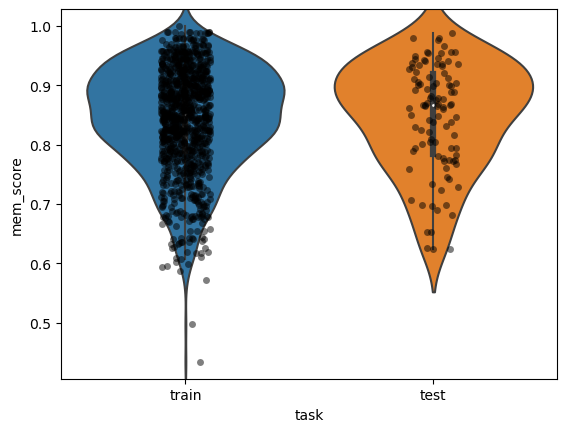

In [3]:
project_root = "/data/vision/oliva/scratch/blahner/BMD_tmp" #os.path.join("/your","local","project","path")

#load the metadata file
with open(os.path.join(project_root,"derivatives","stimuli_metadata","annotations.json"), 'r') as f:
    metadata = json.load(f)

# collect all the memorability scores into an array
mem_arr = np.array([metadata[f"{stim+1:04}"]['memorability_score'] for stim in range(1102)])

#organize the memorability scores by task and plot
data_plot = {'task': [], 'mem_score': []}
for i in range(1102):
    if i < 1000:
        data_plot['task'].append('train')
    elif i >= 1000:
        data_plot['task'].append('test')
        
    data_plot['mem_score'].append(metadata[f"{i+1:04}"]['memorability_score'])
df = pd.DataFrame(data=data_plot)
sns.violinplot(x="task",y="mem_score",data=data_plot)
sns.stripplot(x="task", y ="mem_score", data=data_plot, color="black", edgecolor="gray", alpha=0.5)

In [9]:
beta_root = os.path.join(project_root,"versionA","prepared_data", "prepared_allvoxel_pkl")


In [13]:
dims = (78, 93, 71)
voxels = dims[0]*dims[1]*dims[2]
string_identifier = "_TRavg-56789"
subjects= ['sub-01'] #['sub-01','sub-02','sub-03','sub-04','sub-05','sub-06','sub-07','sub-08','sub-09','sub-10']
col = ['ROI','Correlation_Mean','Task','Subject']
data_plot = {c: [] for c in col}
#roi memorability correlation
ROI_LUT = {'V1v': 1,'V1d': 2,'V2v': 3,'V2d': 4,'V3v': 5,'V3d': 6,'hV4': 7,'EBA': 8,'FFA': 9,'OFA': 10,'STS': 11,
               'LOC': 12,'PPA': 13,'RSC': 14,'TOS': 15,'V3ab': 16,'IPS0': 17,'IPS1-2-3': 18,
               '7AL': 19, 'BA2': 20, 'PFt': 21, 'PFop': 22, 'WB': 99}
for sub in subjects:
    print(sub)
    sub_zfill = "".join(sub.split('-'))
    for ROI, LUT in ROI_LUT.items():
        with open(os.path.join(beta_root, sub_zfill, f"{ROI}{string_identifier}_allvoxel.pkl"), 'rb') as f:
            data = pickle.load(f)

        train_data = np.mean(data["train_data_allvoxel"],axis=1) #average across repetitions
        test_data = np.mean(data["test_data_allvoxel"],axis=1) #average across repetitions
        num_voxels = data["train_data_allvoxel"].shape[2]
        betas = np.zeros((1102,num_voxels)) #initialize beta array
        
        betas[:1000,:] = train_data
        betas[1000:1102,:] = test_data
        del train_data, test_data, data

        #calculate observed correlation
        rho_obs=np.zeros(num_voxels)
        pval_tmp = np.zeros(num_voxels)
        for v in tqdm(range(num_voxels)):
            spear_corr = stats.spearmanr(mem_arr, betas[:,v])
            rho_obs[v] = spear_corr[0]
            pval_tmp[v] = spear_corr[1] 
        
        n = len(rho_obs)
        if n > 0: #if some voxels are not nan...
            data_plot['ROI'].append(ROI)
            data_plot['Correlation_Mean'].append(np.nanmean(rho_obs))
            data_plot['Task'].append("TestTrain")
            data_plot['Subject'].append('sub-' + sub)
    
        else:
            data_plot['ROI'].append(ROI)
            data_plot['Correlation_Mean'].append(np.nan)
            data_plot['Task'].append("TestTrain")
            data_plot['Subject'].append('sub-' + sub)


sub-01


  0%|          | 0/320 [00:00<?, ?it/s]

100%|██████████| 98273/98273 [00:48<00:00, 2042.80it/s]


In [14]:
df = pd.DataFrame(data=data_plot)

/data/vision/oliva/blahner/anaconda3/envs/NeuroAI/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/data/vision/oliva/blahner/anaconda3/envs/NeuroAI/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


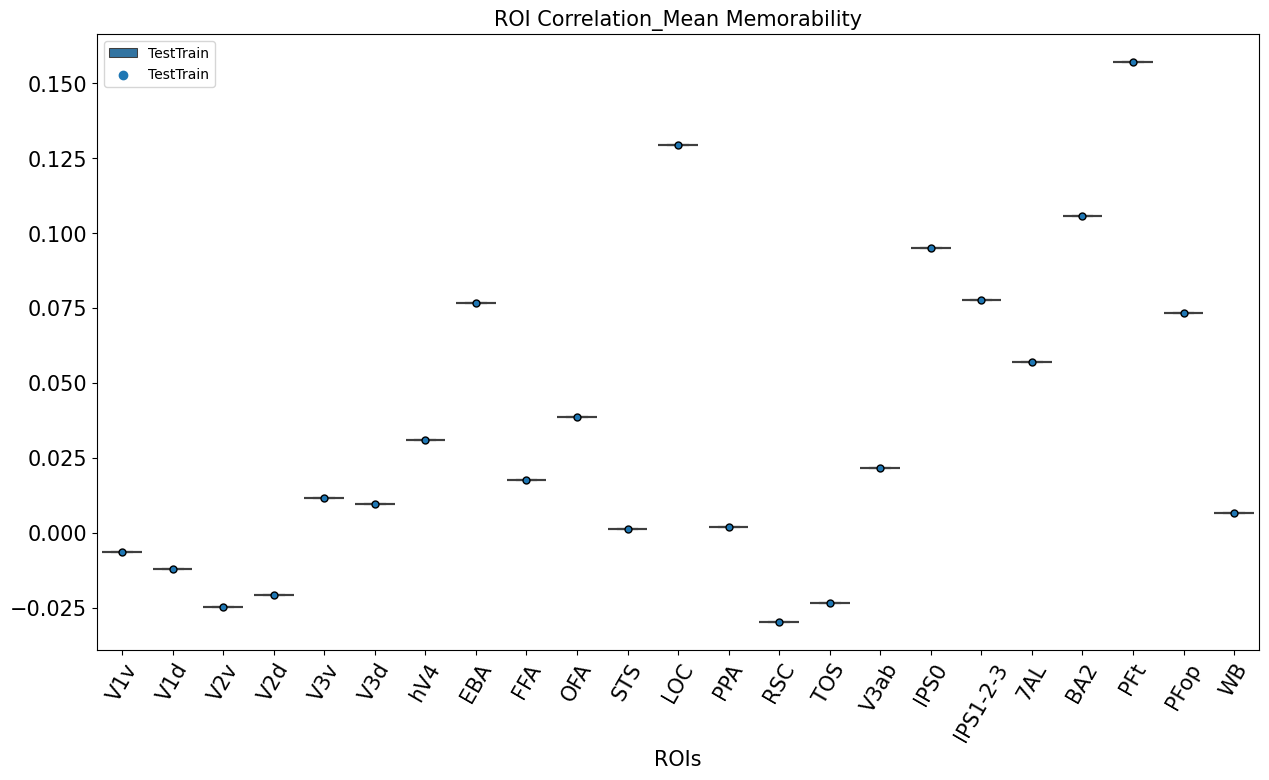

In [15]:
y_label = "Correlation_Mean"
fs=20 #fontsize
ax = sns.boxplot(x="ROI", y=y_label, hue="Task", data=df)
sns.stripplot(x="ROI", y=y_label, hue="Task", data=df, edgecolor='black',linewidth=1)

fs = 15
ax.set_title(f"ROI {y_label} Memorability", fontsize=fs)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 60)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
ax.set_ylabel('')
ax.set_xlabel('ROIs', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
ax.legend().set_visible(True)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.show()

In [ ]:
method = "poscorr"

corr_3D_all = np.zeros((len(subjects), dims[0], dims[1], dims[2]))

for s, sub in enumerate(subjects):
    print(sub)
    #load the subject's betas-memorability correlations. These spearman correlations are FDR corrected for each subject separately
    fname = 'sub-' + sub + '_memorabilityBetasAvgOverTrials_task-testtrain_corr-spearman_stats-FDRq-0.05-' + method + '_wbfiles.pkl'

    with open(os.path.join(mem_root, fname), 'rb') as fh:
       mem_arr,pval,FDRadj, corr, nan_indices = pickle.load(fh)
    
    corr_1D = np.ones((n_voxels,))
    corr_1D[nan_indices.astype(int)] = 0
    corr_1D[corr_1D == 1] = corr
    corr_3D = corr_1D.reshape(dims)
    corr_3D_all[s,:,:,:] = corr_3D #put all the subject's betas-memorability correlations into one 4D array
    del corr, pval, FDRadj, nan_indices, corr_3D, corr_1D
    
corr_1D_all = corr_3D_all.reshape((len(subjects),-1)) #reshape into subjects x voxels matrix
#do ttest
pval = np.zeros((n_voxels,))
for vox in tqdm(range(n_voxels)): #loop over every voxel. don't need if we have pval of permulation.
    pval[vox] = stats.ttest_1samp(corr_1D_all[:,vox], popmean=0, nan_policy='omit', alternative='greater')[1] #perform ttest at each voxel with correlations of the 10 subjects. get pvalues per voxel. null hypothesis mean of 0 correlation.

#do FDR correction
rejected, pval_corrected = fdrcorrection(pval[~np.isnan(pval)], alpha = 0.05,  method = method, is_sorted = False) #FDR correction to get the significant voxels over all subjects

#plot average correlation masked by FDR significance
pval_mask = np.ones((n_voxels,))
pval_mask[np.isnan(pval)] = 0 #make all nan voxels 0 (outside the brain)
pval_mask[pval_mask==1] = rejected #make all voxels that survived the FDR correction have value of 1
pval_mask_3D = pval_mask.reshape(dims) #reshape this FDR mask to 3D

corr_avg_3D = np.nanmean(corr_3D_all, axis=0) #simply average the subjects' correlations at each voxel
corr_avg_3D_masked = corr_avg_3D * pval_mask_3D #now mask this average correlation with the FDR mask

nii_save_path = os.path.join(save_root, 'memorability_task-testtrain_wb_ttestFDR_masked.nii')
savepath = os.path.join(save_root,'memorabilityBetasAvgOverTrialstask-testtrain_wb_ttestFDR_masked_spearmancorr_glassbrain_wbfiles.svg')
visualize_glass_brain(nii_save_path, corr_avg_3D_masked, root, savefig=savepath)